# Example of application to matlab files and (partial) replication of results from Anderson et al. 2016

In [1]:
import numpy as np
import scipy.io
import os
import xarray as xr
import pyhsmm_mvpa as hsmm
import itertools
import multiprocessing 
import matplotlib.pyplot as plt
from mne import channels

cpus = multiprocessing.cpu_count()

%load_ext autoreload
%autoreload 2


# Initial fit

Reading the data

In [2]:
mat = scipy.io.loadmat('matlab/newbumps/starter.mat')

data = np.array(mat['normedscore10'])
starts = np.array(mat['x'][:,0]) -1#correcting to be 0 indexed
ends = np.array(mat['y'][:,0])-1#correcting to be 0 indexed
subjects = np.array(mat['subjects'])-1 #correcting to be 0 indexed

montage = mne.channels.make_standard_montage("biosemi32")#position of electrodes is assumed to be standard
positions = np.array([x[-1][:2] for x in np.array(list(montage.get_positions()['ch_pos'].items()))[:,:]])


/tmp/ipykernel_53311/1801879987.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  positions = np.array([x[-1][:2] for x in np.array(list(montage.get_positions()['ch_pos'].items()))[:,:]])


Recreating positions of electrodes

In [108]:
positions_dict_i = [{str(electrode[0][0]):[electrode[5][0][0]/1000,electrode[4][0][0]/1000,electrode[6][0][0]/1000]} for electrode in mat['cl'][0]]
positions_dict = {}
for i in positions_dict_i:
     positions_dict.update(i)
montage = channels.make_dig_montage(positions_dict,coord_frame='head')
positions = np.array([x[-1][:2] for x in np.array(list(montage.get_positions()['ch_pos'].items()))[:,:]])
#montage.plot()

/tmp/ipykernel_53311/2215826066.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  positions = np.array([x[-1][:2] for x in np.array(list(montage.get_positions()['ch_pos'].items()))[:,:]])


Initializing the hsmm object with data, starts, sampling frequency... all things shared across the different following fit

In [5]:
init = hsmm.hsmm(data, starts, ends, sf=100, bump_width=50, cpus=5)

Estimating n_bump model with backward estimation

In [6]:
filename = 'testing.nc'

if filename not in os.liustdir():
    bests = init.backward_estimation()
    bests.to_netcdf('testing.nc')
else:
    bests = xr.open_dataset('testing.nc')
bests

Estimating parameters for 8 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:474: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:480: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 8 bumps model
Estimating all solutions for 7 bumps
Estimating all solutions for 6 bumps
Estimating all solutions for 5 bumps
Estimating all solutions for 4 bumps
Estimating all solutions for 3 bumps
Estimating all solutions for 2 bumps
Estimating all solutions for 1 bumps


<xarray.Dataset>
Dimensions:      (n_bumps: 8, stage: 9, params: 2, component: 10, bump: 8,
                  samples: 300, trial: 18271)
Coordinates:
  * n_bumps      (n_bumps) int64 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -4.647e+04 -3.822e+04 ... -7.554e+04
    parameters   (n_bumps, stage, params) float64 2.0 3.151 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.2828 0.809 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

Plotting the likelihood and estimated bumps

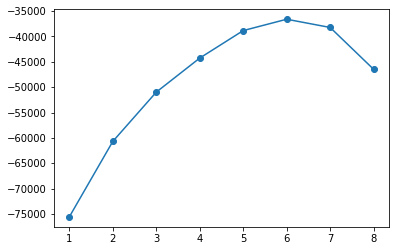

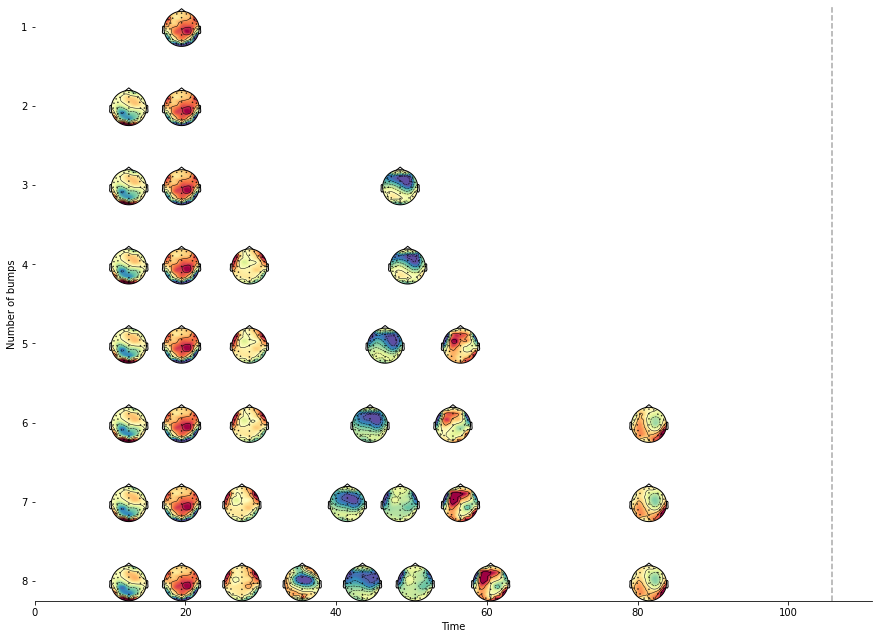

In [110]:
plt.plot(np.arange(init.max_bumps)+1, bests.likelihoods[::-1],'o-')
plt.show()
hsmm.plot_topo_timecourse(bests.magnitudes, bests.eventprobs, xr.DataArray(mat['coeff10'][:,:10]).data, positions,
    bump_size=5, time_step = 1, magnify=1, mean_rt = np.mean(ends- starts),
    figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps, 0,-1)})

LOOCV _note that we cannot use the dedicated function in HsMM because the data is not an xarray_

In [ ]:
#Looping over possible number of bumps
subjects_idx = np.unique(subjects)
likelihoods_loo = []

for subject in subjects_idx:
    print(f'Subject {subject}')
    #Extracting data from left out subject
    subjects_idx_loo = subjects_idx[subjects_idx != subject]

    starts_left_out_idx = np.array([starts[idx] for idx, s in enumerate(subjects) if s not in subjects_idx_loo])
    ends_left_out_idx = np.array([ends[idx] for idx, s in enumerate(subjects) if s not in subjects_idx_loo])

    #Correct starts indexes to account for reoved subject, whole indexing needs improvement
    starts_loo = np.concatenate([starts[starts < starts_left_out_idx[0]], starts[starts > ends_left_out_idx[-1]]-ends_left_out_idx[-1]+1])
    ends_loo = np.concatenate([ends[ends < starts_left_out_idx[0]], ends[ends > ends_left_out_idx[-1]]-ends_left_out_idx[-1]])
    ends_loo[-1] = ends_loo[-1]-1
    starts_left_out = np.array([start - starts_left_out_idx[0]  for start in starts if start >= starts_left_out_idx[0] and start <= ends_left_out_idx[-1]])
    ends_left_out = np.array([end - starts_left_out_idx[0]  for end in ends if end >= starts_left_out_idx[0] and end <= ends_left_out_idx[-1]])


    samples_loo = np.array([sample for idx,sample in enumerate(data) if idx < starts_left_out_idx[0] or idx > ends_left_out_idx[-1]])
    samples_left_out = np.array([sample for idx,sample in enumerate(data) if idx >= starts_left_out_idx[0] and idx <= ends_left_out_idx[-1]])
    #Fitting the HsMM using previous estimated parameters as initial parameters
    model_loo = hsmm.hsmm(samples_loo, starts_loo, ends_loo, sf=100)
    with multiprocessing.Pool(processes=cpus) as pool:
        iterative_results_loo = pool.starmap(model_loo.fit_single, 
            zip(np.arange(init.max_bumps,0,-1),#init.max_bumps to ensure that same number of maxbumps
                bests.magnitudes, bests.parameters, itertools.repeat(1), itertools.repeat(False), itertools.repeat(True)))
    iterative_results_loo = xr.concat(iterative_results_loo, dim="n_bumps")
    
    model_left_out = hsmm.hsmm(samples_left_out, starts_left_out, ends_left_out, sf=100)
    with multiprocessing.Pool(processes=cpus) as pool:
        likelihoods = pool.starmap(model_left_out.calc_EEG_50h, 
            zip(iterative_results_loo.magnitudes,
                iterative_results_loo.parameters,
                np.arange(init.max_bumps,0,-1),itertools.repeat(True),itertools.repeat(True)))
    likelihoods_loo.append(likelihoods)
    np.save('likelihoods_loo',likelihoods_loo)

Subject 0
Estimating parameters for 8 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 7 bumps model
